# PART I : Pre-processing in Qupath 

## 1.1 Cores extraction

**Objectives:** Extract all cores using TMA dearrayer and save as images using the script.

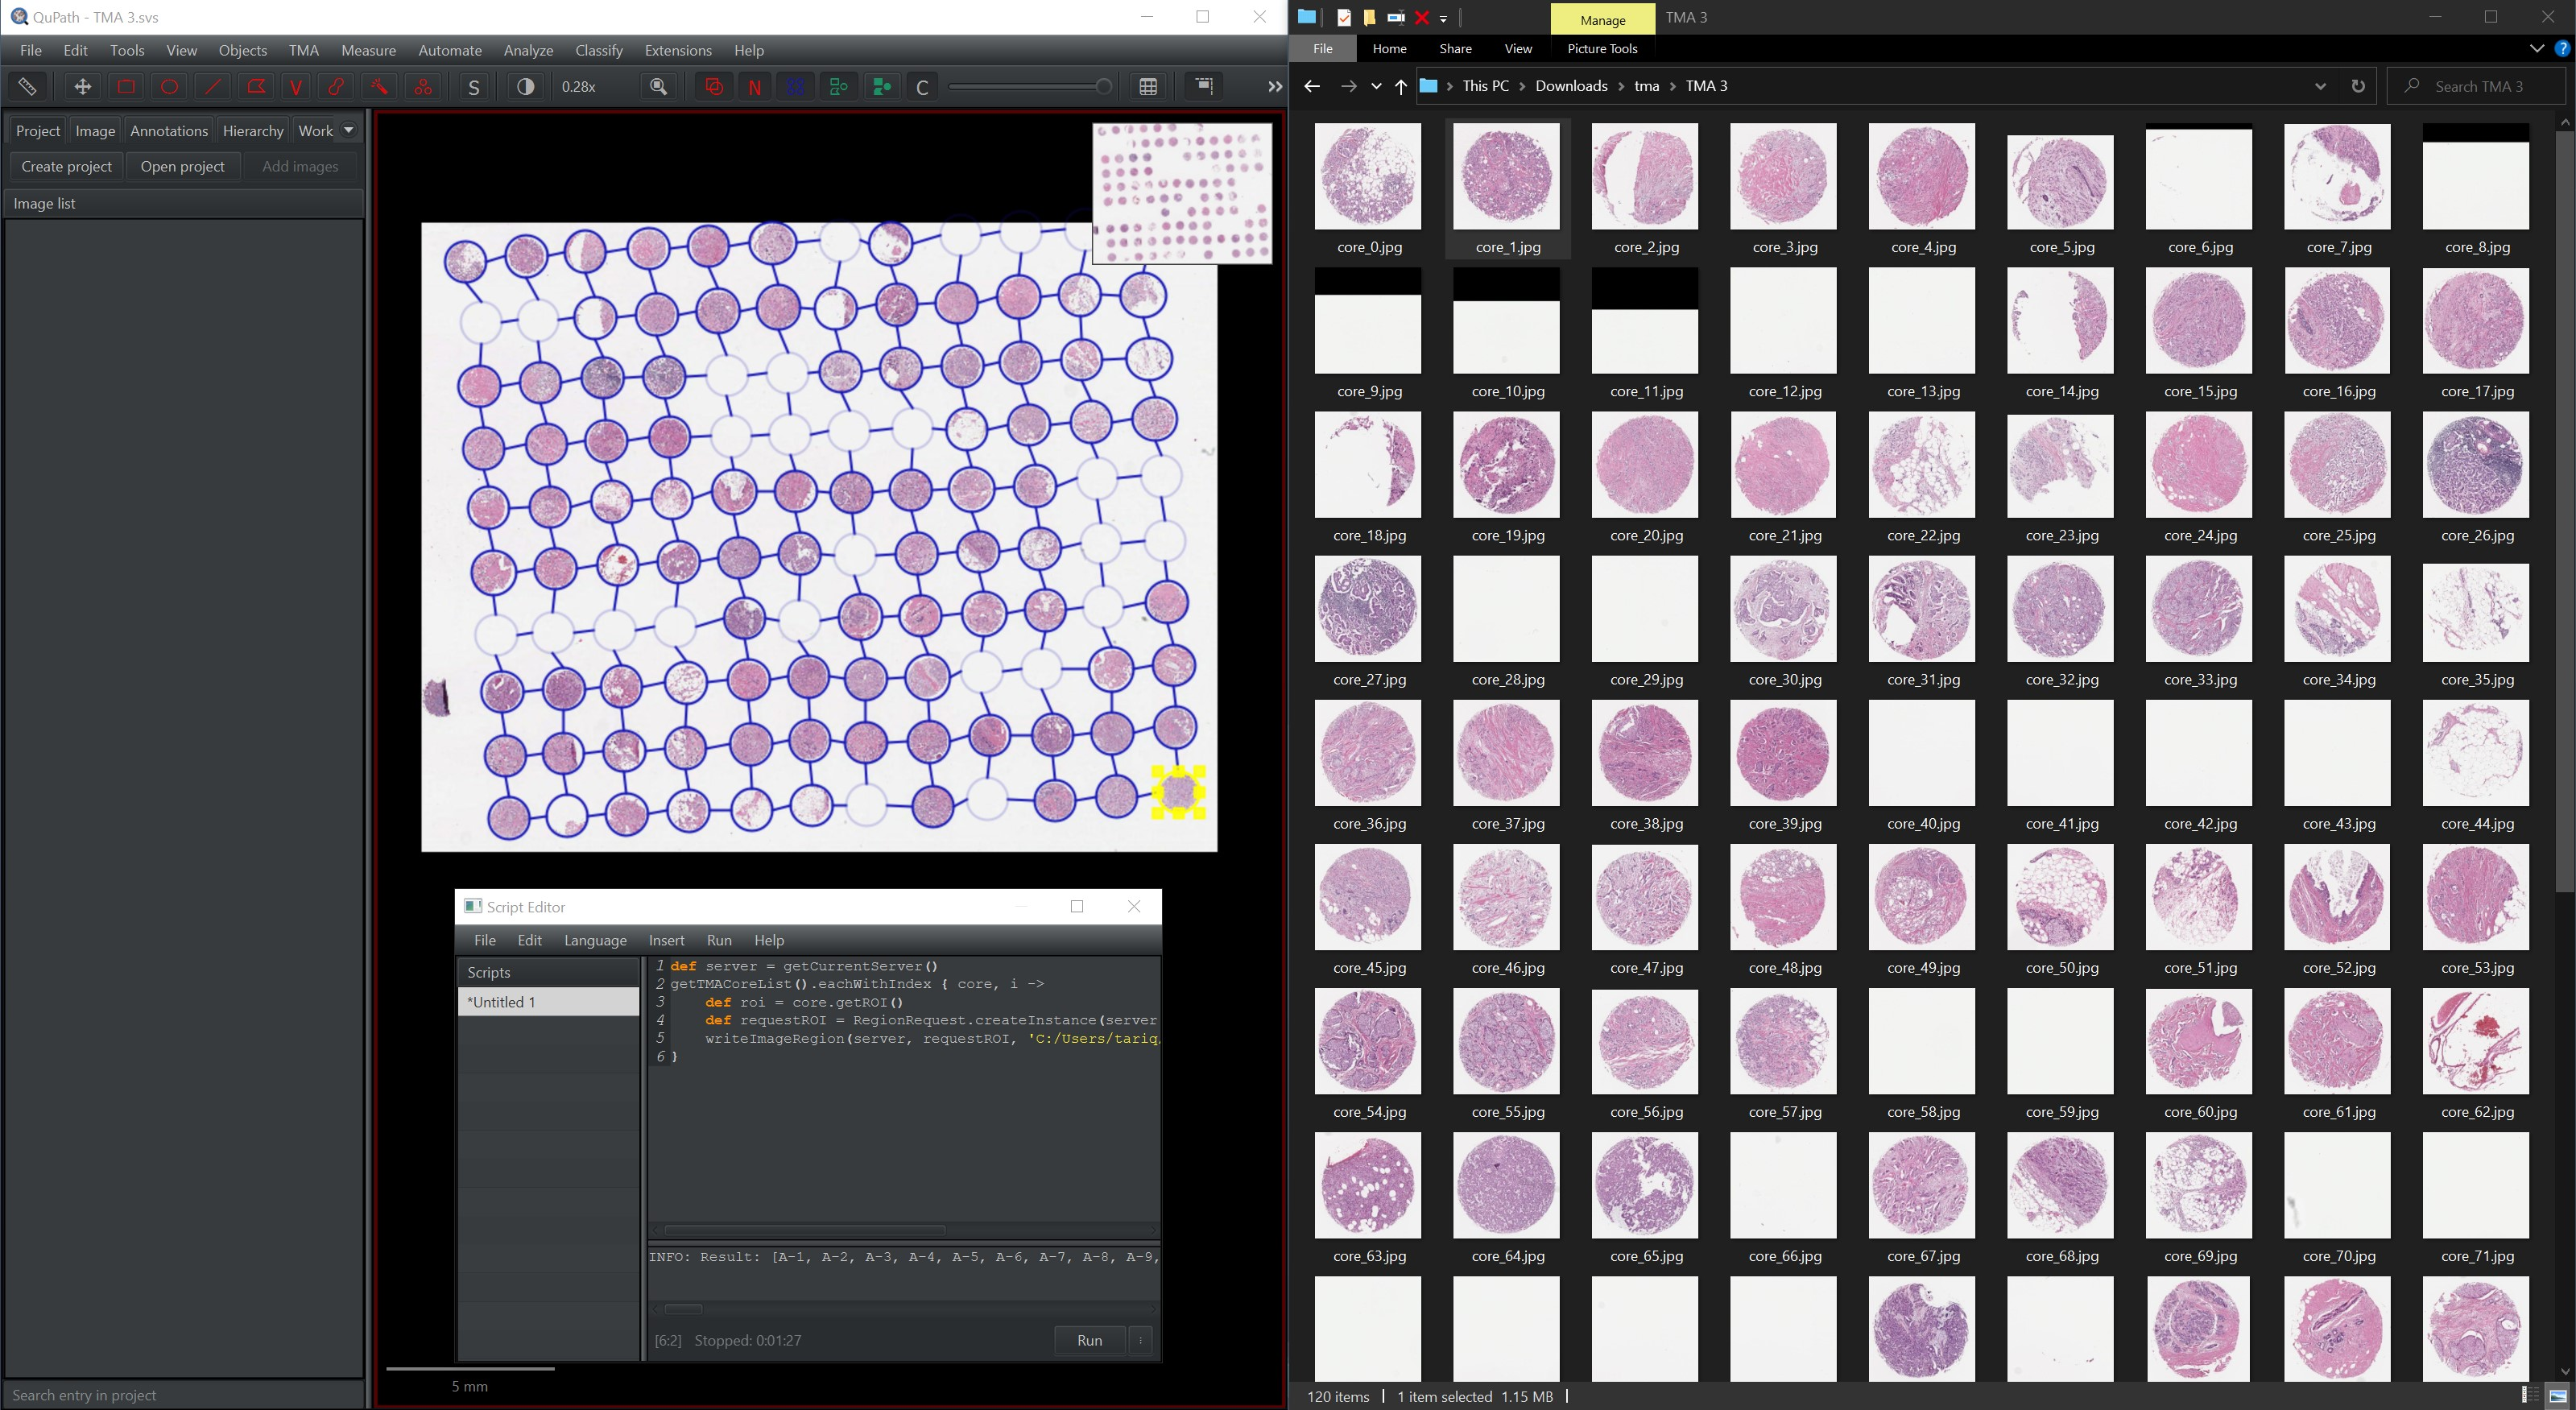

1. Load TMA images (`.svs` format) into Qupath (if not yet loaded).
  - set type of images (`Brightfield H&E`)
2. De-array the cores:
  - `TMA` > `TMA dearrayer` >
    - TMA core diameter (default: `1.2mm`)
    - change column labels (`1-12`)
    - row labels (`A-J`)
    - density threshold (default: `5.0`)
    - bounds scale factor (default: `105.0`)
    - then click Run and close the window once finish
3. Adjust the cores:
  - `Measure` > `Show TMA Measurement`
    - click and check the cores one by one
    - adjust if necessary, use mouse scroll to zoom in/out, use arrow keys to move between cores
    - click `Save`, this will save centroid points (if needed)
4. Exporting all the cores
  - `Automate` > `Show script editor` 
    - copy the following script (change the directory path to your directoryand change the image format .jpg/.tif):
```
def server = getCurrentServer()
getTMACoreList().eachWithIndex { core, i ->
def roi = core.getROI()
def requestROI = RegionRequest.createInstance(server.getPath(), 1, roi)
writeImageRegion(server, requestROI, 'C:/Users/file/path/core_' + i + '.tif')
}
```
    - code is from [Melvin Bard](https://forum.image.sc/t/how-to-split-tma-into-he-slides/43221).
  - paste into the editor click `Run`.

## 1.2 Getting reference image

**Objectives:** To have a reference image when we do colour correction step later.

Colour correction in Qupath is done according to [here](https://www.imagescientist.com/brightfield-color-deconvolution).

1. `Analyze` > `Pre-processing` > `Estimate stain vector`
 - check `Exclude unrecognised colour`
 - click `Auto` (usually good enough) > `OK`
2. Choose one core > `File` > `Export images` > `Original pixels`
 - choose TIF format and save.

> Lessons to be learned in this section:
* changing `bounds scale factor` will change the output resolution
* changing `bounds scale factor` will not alter the tissue size when zoomed 100%
* any colour editing done in Qupath won't be applied if running the script for exporting the cores
* change `\` in file path to `/` in the script path is copied in Windows
* alternatively, can use python approach [here](http://www.andrewjanowczyk.com/de-array-a-tissue-microarray-tma-using-qupath-and-python/) (tried but error)

# PART II: Preprocessing in Python

## 2.1 8-bit conversion 

Get the images from Google Drive.

In [1]:
# connect to GDrive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
# import libraries
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# get the images
IMG_PATH = '/content/gdrive/MyDrive/SCIN/TMA/export/core_3.tif'
IMG_PATH_ref = '/content/gdrive/MyDrive/SCIN/TMA/data/TMA_3_reference.tif'

# open in imageIO
img = imageio.imread(IMG_PATH)
img_ref = imageio.imread(IMG_PATH_ref)
print(img.shape, img_ref.shape)

(2509, 2509, 3) (2508, 2508, 3)


Conversion to 8 bit is based on [here](https://www.youtube.com/watch?v=3vj3MTkBhWg).

In [4]:
## normalised then convert to 8 bit

# for img
img_8bit = (img / img.max()) * 255
img_8bit = np.uint8(img_8bit)
print(img_8bit.shape, img_8bit.dtype)

# for reference img
img_ref_8bit = (img_ref / img_ref.max()) * 255
img_ref_8bit = np.uint8(img_ref_8bit)
print(img_ref_8bit.shape, img_ref_8bit.dtype)

(2509, 2509, 3) uint8
(2508, 2508, 3) uint8


## 2.2 Colour correction

**Objectives:** To standardise eosin and haemotocylin stains colour especially if the slide coming from different machines.

In [6]:
# clone and install dependencies
!git clone https://github.com/sebastianffx/stainlib
!mv /content/stainlib /content/stainlib2
!mv /content/stainlib2/stainlib /content
!mv /content/stainlib2/setup.py /content/stainlib
!pip install -e stainlib/

Cloning into 'stainlib'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 140 (delta 45), reused 111 (delta 20), pack-reused 0
Receiving objects: 100% (140/140), 10.14 MiB | 6.16 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/stainlib
     |████████████████████████████████| 15.8 MB 7.6 MB/s 
  Running setup.py develop for stainlib


In [7]:
# import libraries
import stainlib
import requests
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
from io import BytesIO
from stainlib.utils.plot_utils import _plot_imagegrid
from stainlib.normalization.normalizer import ExtractiveStainNormalizer, ReinhardStainNormalizer
from stainlib.utils.stain_utils import is_uint8_image

In [8]:
# get the 8 bit images prepared previously
IMG_PATH_ref = img_ref_8bit
IMG_PATH = img_8bit

Colour correction steps:

In [ ]:
# uncomment to choose normalisation method
#normalizer = stainlib.normalization.normalizer.ExtractiveStainNormalizer(method='macenko')
normalizer = stainlib.normalization.normalizer.ExtractiveStainNormalizer(method='vahadane')

#standardised brigtness
target = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(IMG_PATH_ref) 
normalizer.fit(target)
transformed = normalizer.transform(IMG_PATH)

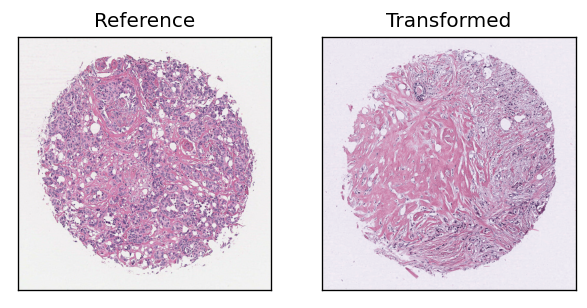

In [13]:
## visulise what's going on
titles = ['Reference', 'Transformed']
images = [IMG_PATH_ref, transformed]

for i in range(len(titles)):
  plt.subplot(1,2,i+1),
  plt.imshow(images[i], 'gray', vmin=0, vmax=512)
  plt.title(titles[i], fontsize=12)
  plt.xticks([]), plt.yticks([])
plt.rcParams['figure.dpi'] = 200
plt.show()

In [14]:
# (optional) save the image if needed
imageio.imwrite('/content/img_transformed.png', transformed)

> Lessons to be learned in this section:
* cloned libraries should directly inside `/contents` folder, copy `setup.py` into it
* other simpler library: [staintools](https://github.com/Peter554/StainTools)
* here if use `cv2.imwrite` to save, the colour of  transformed images shifted
* saving images will output 24-bit depth colour, always use 8-bit images as arrays
* notes: different colour correction method introduce variations when training for neural network, refer paper.

## 2.3 Foreground selection


**Objectives:** To differenct between the tissue and glass slide. Here we use Otsu thresholding.

In [31]:
## import libraries
import cv2         
import numpy as np 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for colab env only

In [46]:
## set img path
IMG_PATH = '/content/img_transformed.png'

Thresholding and masking, refer [link1](https://stackoverflow.com/questions/65414289/crop-colour-image-according-to-otsu-threshold) and [link2](https://evergreenllc2020.medium.com/fundamentals-of-image-thresholding-and-masking-6a89997ccca6) for masking. Refer [link](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) for properly implement Otsu thresholding.

In [47]:
# load images
picture_rgb = cv2.imread(IMG_PATH, -1)
picture = cv2.cvtColor(picture_rgb, cv2.COLOR_BGR2GRAY)

# thresholding
blur = cv2.GaussianBlur(picture,(5,5),0)
threshold, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_OTSU)

# prepare masks
thresh_inv = cv2.bitwise_not(thresh)

'''
# another method but this will shift the colour
stacked = np.dstack((thresh_inv,thresh_inv,thresh_inv))
img = cv2.bitwise_and(picture_rgb, stacked)
foreground = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
foreground[np.all(foreground == (0, 0, 0), axis=-1)] = (255,255,255)
'''

# extract foreground
masked = cv2.bitwise_and(picture_rgb, picture_rgb, mask=thresh_inv)
#cv2_imshow(masked) 

Conversion of the background to black (refer [link](https://stackoverflow.com/questions/64336516/how-to-change-all-the-black-pixels-to-white-opencv))

In [48]:
# copy step is optional
import copy
final_img = copy.deepcopy(masked)

# get (i, j) positions of all RGB pixels that are black (i.e. [0, 0, 0])
black_pixels = np.where(
    (final_img[:, :, 0] == 0) & 
    (final_img[:, :, 1] == 0) & 
    (final_img[:, :, 2] == 0)
)

# set those pixels to white
final_img[black_pixels] = [255, 255, 255]
#cv2_imshow(final_img) 

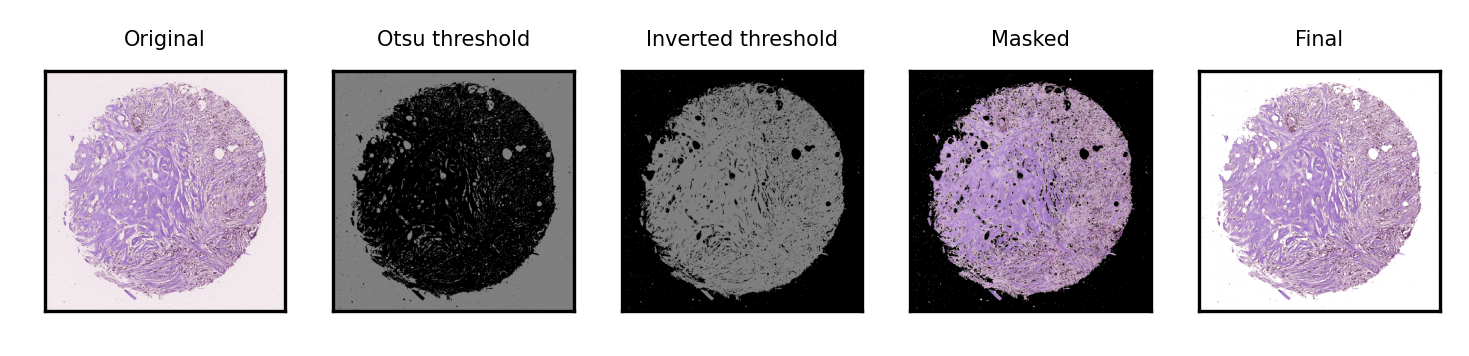

In [49]:
## visulise what's going on
titles = ['Original', 'Otsu threshold', 'Inverted threshold', 'Masked', 'Final']
images = [picture_rgb, thresh, thresh_inv, masked, final_img]

for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=512)
    plt.title(titles[i], fontsize=5)
    plt.xticks([]),plt.yticks([])
#plt.rcParams['figure.dpi'] = 300
plt.show()

!- plotted images using matplotlib might show difference colours, save and download to view the finalised images.

In [50]:
## save the image
#filename = "/content/img_thresholded.tif"
filename = "/content/img_thresholded.png"
img = final_img
cv2.imwrite(filename, img)

True

> Lessons to be learned in this section:
* use `cv2_imshow` to show images in colab
* `THRESH_OTSU` method in OpenCV only accept 8 bit images
* `THRESH_OTSU` without properly set up will remove stains on cell cytoplasm
* direct stacking of two images using `bitwise_and` will alter shift image colours (do not use)
* introducing blur before Otsu has better results 
* use `copy.deepcopy(var)` to duplicate variables in python



# PART III : Segmentation

**Objectives:** To detect the tissue types from our pre-processed H&E images using pre-train model (ResNet Unet Breast Cancer).

This section is simplication from [TIA's Semantic Segmentation notebook](https://colab.research.google.com/drive/1SaVonf-0dQPQJyNScd1GZFZKojwdYg1n#scrollTo=Ykj-czpgG2Da).

## 3.1 Setups

!- restart runtime when prompted after running the code below 

In [21]:
## Installing TIA Toolbox
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1

print("Installation is done.")

Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook~=5.7.16, but you have notebook 6.5.2 which is incompatible.
google-colab 1.0.0 requires tornado~=6.0.4, but you have tornado 6.2 which is incompatible.


Installation is done.


!- change to False if no GPU available

In [1]:
ON_GPU = True  # Should be changed to False if no cuda-enabled GPU is available
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e614bc12-d300-10d7-c5eb-4731ac72e2d6)


In [57]:
## Removing leftovers from previous runs
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
![ -d sample_tile_results ] && !( echo "deleting 'sample_tile_results' directory"; rm -r sample_tile_results)
![ -d sample_wsi_results ] && ( echo "deleting 'sample_wsi_results' directory"; rm -r sample_wsi_results)
![ -d tissue_mask_results ] && ( echo "deleting 'tissue_mask_results' directory"; rm -r tissue_mask_results)
import warnings

warnings.filterwarnings("ignore")

deleting 'sample_tile_results' directory


In [58]:
## Importing related libraries
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
from tiatoolbox.utils.misc import imread
from tiatoolbox.wsicore.wsireader import WSIReader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

## 3.2 Get the data

Data is from from previously prepared H&E sample.

!- change the image path

In [59]:
# Uncomment to get a core from Harvard Dataverse
# !wget -c https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/RRKMHC/3IWD3X -O A_1_11_PTEN_Zeiss_4096.jpg

from tiatoolbox.utils.misc import download_data

# locate the img files
img_path = "/content/img_thresholded.png"

# change these file name if needed
img_file_name = img_path
wsi_file_name = img_path
mini_wsi_file_name = img_path
model_file_name = img_path

## 3.3 Semantic segmentation


We are using ResNet Unet BCSS pretrained model, we can identify:
- Tumour
- Stroma
- Inflammatory
- Necrosis
- Others (nerves, vessels, blood cells, adipose, etc.)

> More information on the model and the dataset used for training can be found [here](https://academic.oup.com/bioinformatics/article/35/18/3461/5307750) (_Amgad et al., "Structured crowdsourcing enables convolutional segmentation of histology image"_) and the data is available for download using this [link](https://github.com/PathologyDataScience/BCSS).



In [60]:
# Tile prediction
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4,
    batch_size=4,
)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/fcn_resnet50_unet-bcss.pth
Save to /root/.tiatoolbox/models/fcn_resnet50_unet-bcss.pth


!- change patch_input_shape or other parameters accodingly, refer original Notebook.

In [61]:
output = bcc_segmentor.predict(
    [img_file_name],
    save_dir="sample_tile_results/",
    mode="tile",
    resolution=1.0,
    units="baseline",
    patch_input_shape=[1024, 1024], # default is 1024
    patch_output_shape=[512, 512], # depends on model, bcss is half from input
    stride_shape=[128, 128], # default is 512
    on_gpu=ON_GPU,
    crash_on_exception=True,
)

Process Batch: 100%|##########################| 100/100 [01:00<00:00,  1.64it/s]


prediction method output is: [['/content/img_thresholded.png', '/content/sample_tile_results/0']]
Raw prediction dimensions: (2509, 2509, 5)
Processed prediction dimensions: (2509, 2509)
Input image dimensions: (2509, 2509, 3)


Text(0.5, 0.82, 'Processed prediction map')

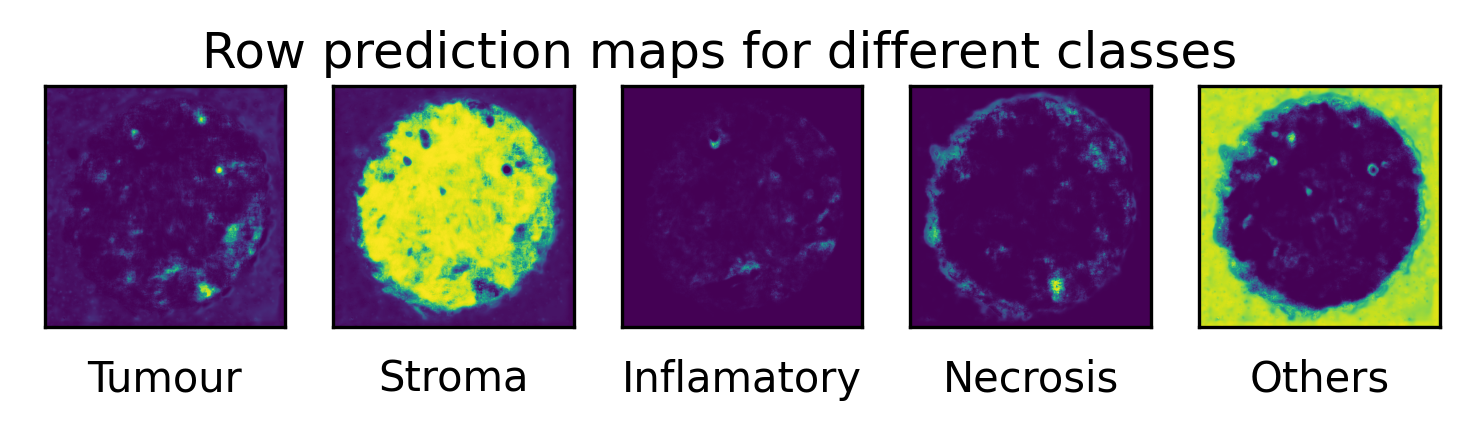

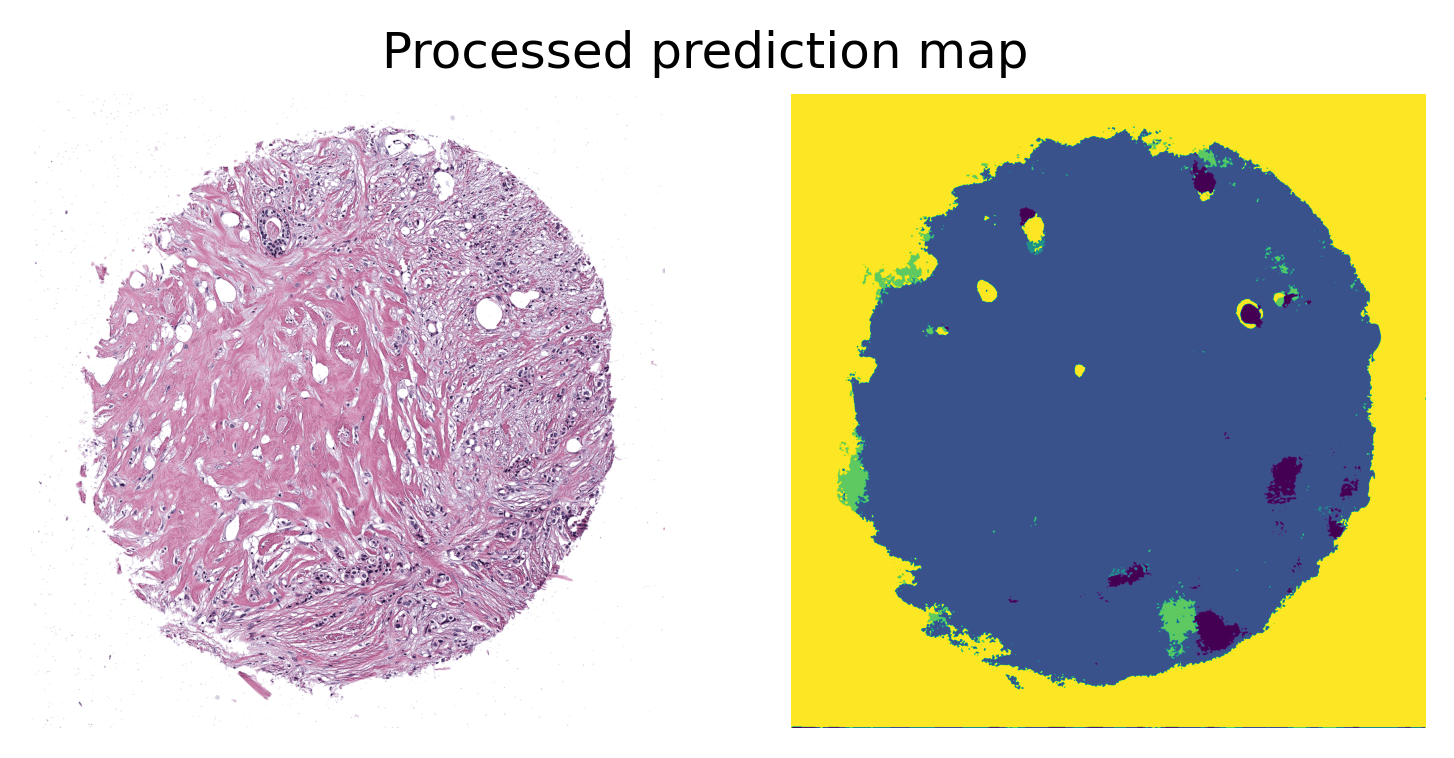

In [63]:
print("prediction method output is: {}".format(output))
tile_prediction_raw = np.load(
    output[0][1] + ".raw.0.npy"
)  # Loading the first prediction [0] based on the output address [1]
print("Raw prediction dimensions: {}".format(tile_prediction_raw.shape))

# Simple processing of the raw prediction to generate semantic segmentation task
tile_prediction = np.argmax(
    tile_prediction_raw, axis=-1
)  # select the class with highest probability
print("Processed prediction dimensions: {}".format(tile_prediction.shape))

# showing the predicted semantic segmentation
tile = imread(img_file_name)
print("Input image dimensions: {}".format(tile.shape))

fig = plt.figure()
label_names_dict = {
    0: "Tumour",
    1: "Stroma",
    2: "Inflamatory",
    3: "Necrosis",
    4: "Others",
}
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(tile_prediction_raw[:, :, i]), plt.xlabel(
        label_names_dict[i]
    ), ax.axes.xaxis.set_ticks([]), ax.axes.yaxis.set_ticks([])
fig.suptitle("Row prediction maps for different classes", y=0.65)

# showing processed results
fig2 = plt.figure()
ax1 = plt.subplot(1, 2, 1), plt.imshow(tile), plt.axis("off")
ax2 = plt.subplot(1, 2, 2), plt.imshow(tile_prediction), plt.axis("off")
fig2.suptitle("Processed prediction map", y=0.82)

> Lessons to be learned in this section:
* proper background threshold remove unwanted predictions (tested)
* smaller `patch_input_shape` will show pathces in predictions
* the smaller the `stride_shape`, the longer the compute time 